In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

(diagnostic_posterior_predictive)=
# Diagnostics for Posterior Predictive

We introduce measures that quantify how good the posterior predictive distribution is.

## Example (Quadratic)

We start with our quadratic synthetic example because we know that our model is adequate.
You will see how the standarized errors will turn out perfect.

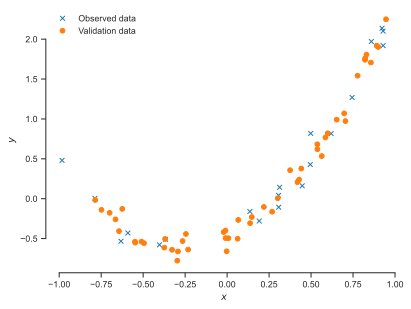

In [2]:
np.random.seed(12345)

num_obs = 20
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 1.0
w2_true = 2.0
sigma_true = 0.1

true_func = lambda x: (
    w0_true
    + w1_true * x
    + w2_true * x ** 2
)

observe_func = lambda x: (
    true_func(x)
    + sigma_true * np.random.randn(x.shape[0])
)

y = observe_func(x)

num_valid = 50
x_valid = -1.0 + 2 * np.random.rand(num_valid)
y_valid = observe_func(x_valid)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's copy-paste again our previous code.

:::{note}
It is generally a bad idea to copy-paste your code from notebook to notebook.
Copy-pasting can introduce bugs that are very hard to fix.
The best approach would be to put all our code in a text file, say `regression.py`
and then import everything from the file.
We will try this out in the homework assignment.
:::

In [6]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

def plot_posterior_predictive(
    model,
    xx,
    phi_func,
    phi_func_args=(),
    y_true=None
):
    """Plot the posterior predictive separating
    aleatory and espitemic uncertainty.
    
    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.
    
    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    y_true        -- The true response for plotting.
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    yy_mean, yy_measured_std = model.predict(
        Phi_xx,
        return_std=True
    )
    sigma = np.sqrt(1.0 / model.alpha_)
    yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std

    fig, ax = plt.subplots()
    ax.plot(xx, yy_mean, 'r', label="Posterior mean")
    ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color='red',
        alpha=0.25,
        label="95% epistemic credible interval"
    )
    ax.fill_between(
        xx,
        yy_lae,
        yy_le,
        color='green',
        alpha=0.25
    )
    ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color='green',
        alpha=0.25,
        label="95% epistemic + aleatory credible interval"
    )
    ax.plot(x, y, 'kx', label='Observed data')
    if y_true is not None:
        ax.plot(xx, y_true, "--", label="True response")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)
    
def plot_posterior_samples(
    model,
    xx,
    phi_func,
    phi_func_args=(),
    num_samples=10,
    y_true=None,
    nugget=1e-6 
):
    """Plot posterior samples from the model.
    
    Arguments:
    model    -- A trained model.
    xx       -- The points on which to evaluate
                the posterior predictive.
    phi_func -- The function to use to compute
                the design matrix.
    
    Keyword Arguments:
    phi_func_args -- Any arguments passed to the
                     function that calculates the
                     design matrix.
    num_samples   -- The number of samples to take.
    y_true        -- The true response for plotting.
    nugget        -- A small number to add the covariance
                     if it is not positive definite
                     (numerically).
    """
    Phi_xx = phi_func(
        xx[:, None],
        *phi_func_args
    )
    m = model.coef_
    S = model.sigma_
    w_post = st.multivariate_normal(
        mean=m,
        cov=S + nugget * np.eye(S.shape[0])
    )
    fig, ax = plt.subplots()
    for _ in range(num_samples):
        w_sample = w_post.rvs()
        yy_sample = Phi_xx @ w_sample
        ax.plot(xx, yy_sample, 'r', lw=0.5)
    ax.plot([], [], "r", lw=0.5, label="Posterior samples")
    ax.plot(x, y, 'kx', label='Observed data')
    ax.plot(xx, yy_true, label='True response surface')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True);

Let's fit the model using automatic relevance determination:

In [7]:
from sklearn.linear_model import ARDRegression

# Parameters
degree = 4

# Design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)

# Fit
model = ARDRegression(
    fit_intercept=False
).fit(Phi, y)

Let's visualize the resulting model:

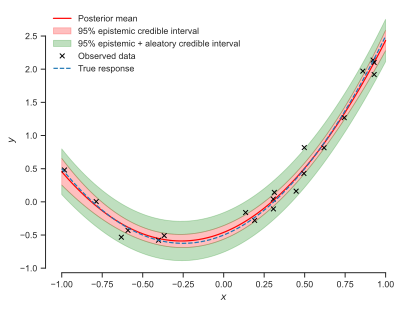

In [8]:
xx = np.linspace(-1, 1, 100)

plot_posterior_predictive(
    model,
    xx,
    get_polynomial_design_matrix,
    phi_func_args=(degree,),
    y_true=true_func(xx)
)

And now let's make predictions on the validation data:

In [9]:
Phi_valid = get_polynomial_design_matrix(
    x_valid[:, None],
    degree
)
y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)

First, let's do the observations vs predictions plot:

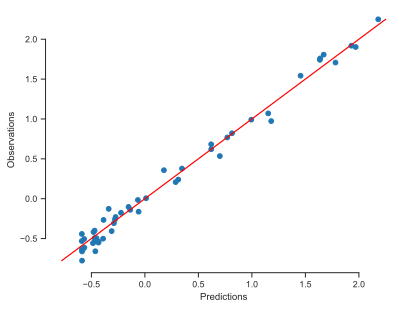

In [10]:
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

It's okay. However, notice that the predictions do not fall on the red line because there is a little noise in the observations.

Let's now compute the standardized errors:

In [11]:
eps = (y_valid - y_predict) / y_std

Remember that the standardized errors must follow a standard normal if the model is correct.
There are various ways to check this.
First, let's plot them:

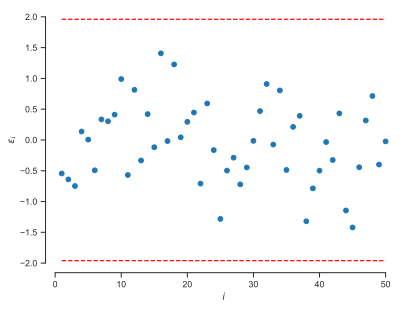

In [12]:
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
sns.despine(trim=True);

Notice that most standardized errors fall within the 95% central credible interval for $N(0,1)$, indicating that the model is good.

The other plot we can do is the histogram of the standardized errors compared to the probability density of the standard normal:

What if you wanted to get the samples from the posterior?
You would have to do a little bit of manual work to translate the posterior weights and their variance back to the original values...

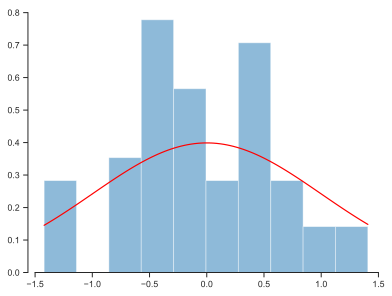

In [13]:
import scipy.stats as st

fig, ax = plt.subplots()
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r')
sns.despine(trim=True);

It's not perfect, but it's a good fit.

The final diagnostic is the so-called quantile-quantile plot or q-q plot.
The q-q plot compares the empirical quantiles of the standardized errors (computed by building and inverting the empirical cumulative distribution function; see Lecture 9).
Here is how to do it:

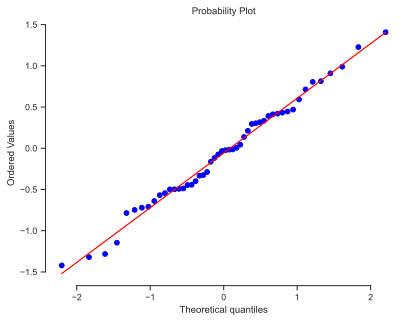

In [14]:
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax)
sns.despine(trim=True);

The q-q plot above also shows a good fit.

### Questions

+ Rerun the code blocks above with many training observations, say 100. Did the diagnostics improve, or are they the same?
+ Keep the number of training observations to 100 and change the validation points to 1000. What do the diagnostics look like now?
+ Let's now try a model that is inadequate for the data. Set the polynomial degree to 1 and rerun everything. What do the diagnostics look like now?